<a href="https://colab.research.google.com/github/Kacper-W-Kozdon/notebook-testing-ivy/blob/main/Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IVY TRANSPILER

Installing kaggle and uploading the API key necessary to use it.

In [1]:
!pip install -q kaggle
from google.colab import files
from google.colab import userdata
import os
files.upload(); #Upload kaggle.json - you can get from the kaggle account settings, from the API section.

Saving kaggle.json to kaggle (1).json


Installing packages necessary to use torch's transformers.

In [2]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses

To use the API, credentials need to be copied into the kaggle folder. If everything works, the output will show the list of available datasets.

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                  title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                  Online Food Dataset                                  3KB  2024-03-02 18:50:30           9955        184  0.9411765        
syedanwarafridi/vehicle-sales-data                   Vehicle Sales Data                                  19MB  2024-02-21 20:16:17          19462        339  1.0              
julianoorlandi/spotify-top-songs-and-audio-features  Spotify Top Songs and Audio Features               526KB  2024-03-18 12:49:50           1374         27  1.0              
bhavikjikadara/student-study-performance             Student

Preparing the ivy library.

In [4]:
#Inser the correct user when cloning the repos. Make sure that they are up-to-date.

!git clone "https://github.com/Kacper-W-Kozdon/demos.git"
!git clone "https://github.com/Kacper-W-Kozdon/ivy.git"
!pip install -U -q ivy accelerate>=0.21.0 mlflow datasets>=2.14.5 nlp 2>/dev/null

fatal: destination path 'demos' already exists and is not an empty directory.
fatal: destination path 'ivy' already exists and is not an empty directory.


Next: import the ivy library and get the dataset.

In [5]:
import ivy
!kaggle datasets download -d danofer/sarcasm
!cp -f sarcasm.zip '/content/demos/Contributor_demos/Sarcasm Detection/'
!unzip '/content/demos/Contributor_demos/Sarcasm Detection/sarcasm.zip' -d '/content/demos/Contributor_demos/Sarcasm Detection/'

sarcasm.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/demos/Contributor_demos/Sarcasm Detection/sarcasm.zip
replace /content/demos/Contributor_demos/Sarcasm Detection/test-balanced.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Import the libraries suggested in the model which is to be transpiled.

In [6]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import gc  # For garbage collection to manage memory
import re  # For regular expressions
import numpy as np  # For numerical operations and arrays

# Libraries to accompany torch's transformers
import tqdm
import boto3
import requests
import regex
import sentencepiece
import sacremoses

import warnings  # For handling warnings
warnings.filterwarnings("ignore")  # Ignore warning messages

import tensorflow as tf
import torch  # PyTorch library for deep learning
from transformers import AutoModel, AutoTokenizer  # Transformers library for natural language processing
from transformers import TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding  # Transformers components for text processing
from transformers import AutoModelForSequenceClassification  # Transformer model for sequence classification

import accelerate

from nlp import Dataset  # Import custom 'Dataset' class for natural language processing tasks
from imblearn.over_sampling import RandomOverSampler  # For oversampling to handle class imbalance
import datasets  # Import datasets library
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import pipeline  # Transformers library for pipelines
from bs4 import BeautifulSoup  # For parsing HTML content

import matplotlib.pyplot as plt  # For data visualization
import itertools  # For working with iterators
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

from datasets import load_metric  # Import load_metric function to load evaluation metrics

from tqdm import tqdm  # For displaying progress bars
tqdm.pandas()  # Enable progress bars for pandas operations

Set the seeds.

In [7]:
tf.keras.utils.set_random_seed(0)
torch.manual_seed(0)

Get the API key for ivy transpiler from your account and upload it to the project. Move it to the correct directory.

In [8]:
files.upload(); #Upload key.pem - you can get from the kaggle account settings, from the API section.

Saving key.pem to key (1).pem


In [9]:
!mkdir ~/.ivy #It might be necessary to change ".ivy" to "ivy".
!cp key.pem ~/.ivy/

mkdir: cannot create directory ‘/root/.ivy’: File exists


First we're loading the tokenizer and the model from torch. All of the basic set-up instructions can be found here: https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/huggingface_pytorch-transformers.ipynb#scrollTo=72d8f2de

In [10]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased')

masked_lm_model = torch.hub.load('huggingface/pytorch-transformers', 'modelForMaskedLM', 'bert-base-cased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
from ivy.stateful.module import Module
from ivy.stateful.sequential import Sequential
from ivy.stateful.layers import *
from ivy.stateful.losses import *
from ivy.stateful.optimizers import *
from ivy.stateful.activations import *
from ivy.stateful.initializers import *
from ivy.stateful.norms import *

In [12]:
ivy.set_backend("tensorflow")
tokenizer_tf = ivy.transpile(tokenizer, source="torch", to="tensorflow")
model_tf = ivy.transpile(model, source="torch", to="tensorflow")
masked_lm_model_tf = ivy.transpile(masked_lm_model, source="torch", to="tensorflow")

In [13]:
df = pd.read_csv("/content/demos/Contributor_demos/Sarcasm Detection/train-balanced-sarcasm.csv")
df = df.drop_duplicates()
df = df.rename(columns={'comment': 'title'})
df = df[['label', 'title']]
df = df[~df['label'].isnull()]
df = df[~df['title'].isnull()]
df.sample(5)

,label,title
242003,0,Congrats to winners and and a BIG thank you to...
861046,1,"Totally did not expect a screenshot with ""No m..."
568738,1,the technology isnt there yet guys
419147,1,"I dunno man, pretty sure this shit happens in ..."
154503,1,"Eww gross, she's not human!"


In [14]:
def count_words(text: str) -> int:
  return len(text.split())

def count_symbols(text: str) -> int:
  return len("".join(text.split()))

df['word_count'] = df["title"].apply(count_words)
df['symbol_count'] = df["title"].apply(count_symbols)
df.sample(5)

,label,title,word_count,symbol_count
797130,0,Routine?,1,8
464103,0,I think Apollos will be a good fit for the team.,11,38
96237,0,It costs 400 000 000$ to fire this weapon for ...,12,46
598115,0,found the city slicker.,4,20
217679,0,"If you think regular St Marys is bad, take a l...",15,54


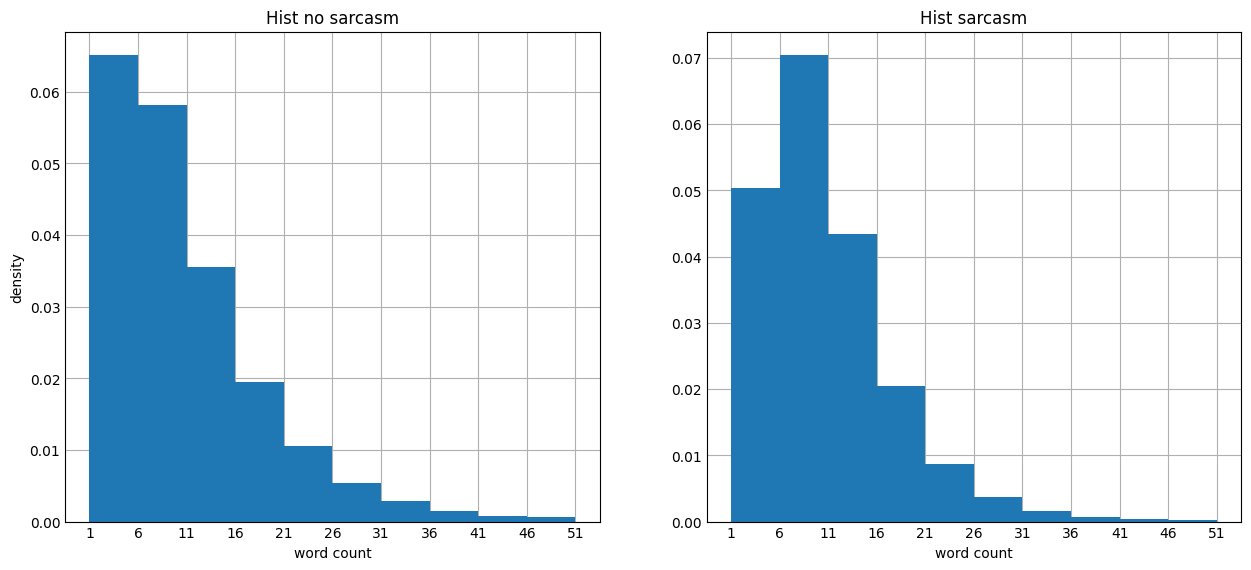

In [59]:
df_no_sarc = df.where(df["label"] == 0)
df_no_sarc = df_no_sarc.where(df_no_sarc["word_count"] <= 51)
df_sarc = df.where(df["label"] == 1)
df_sarc = df_sarc.where(df_sarc["word_count"] <= 51)
df_no_sarc = df_no_sarc[np.isfinite(df_no_sarc["word_count"])]
df_sarc = df_sarc[np.isfinite(df_sarc["word_count"])]
plt.style.use('_mpl-gallery-nogrid')

hist_df_no_sarc, bin_edges_no = np.histogram(df_no_sarc["word_count"].values, density=True)
hist_df_sarc, bin_edges = np.histogram(df_sarc["word_count"].values, density=True)
# plot:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bin_mids_no = [(bin_edges_no[i+1] + bin_edges_no[i])/2 for i in range(len(bin_edges_no) - 1)]
bin_mids = [(bin_edges[i+1] + bin_edges[i])/2 for i in range(len(bin_edges) - 1)]
ax1.bar(bin_mids_no, hist_df_no_sarc, width=bin_edges_no[1] - bin_edges_no[0])
ax2.bar(bin_mids, hist_df_sarc, width=bin_edges[1] - bin_edges[0])
ax1.set_title("Hist no sarcasm")
ax1.set_ylabel("density")
ax1.set_xlabel("word count")
ax1.set_xticks(bin_edges_no)
ax1.grid(True)
ax2.set_title("Hist sarcasm")
ax2.set_xlabel("word count")
ax2.set_xticks(bin_edges)
ax2.grid(True)
plt.show()

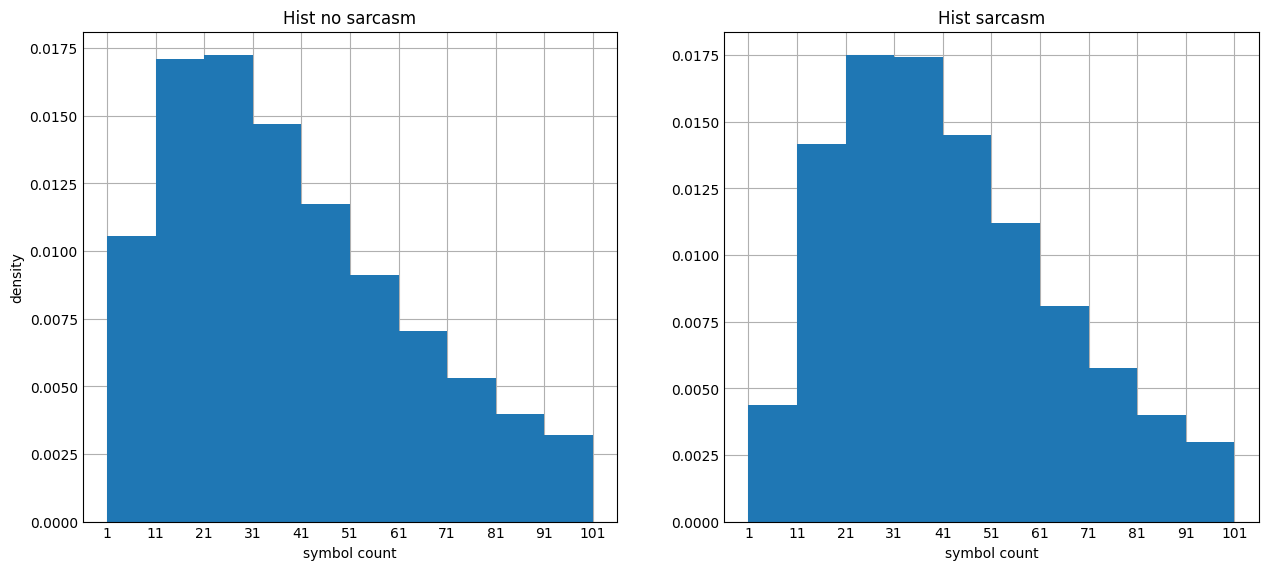

In [61]:
df_no_sarc = df.where(df["label"] == 0)
df_no_sarc = df_no_sarc.where(df_no_sarc["symbol_count"] <= 101)
df_sarc = df.where(df["label"] == 1)
df_sarc = df_sarc.where(df_sarc["symbol_count"] <= 101)
df_no_sarc = df_no_sarc[np.isfinite(df_no_sarc["symbol_count"])]
df_sarc = df_sarc[np.isfinite(df_sarc["symbol_count"])]
plt.style.use('_mpl-gallery-nogrid')

hist_df_no_sarc, bin_edges_no = np.histogram(df_no_sarc["symbol_count"].values, density=True)
hist_df_sarc, bin_edges = np.histogram(df_sarc["symbol_count"].values, density=True)
# plot:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bin_mids_no = [(bin_edges_no[i+1] + bin_edges_no[i])/2 for i in range(len(bin_edges_no) - 1)]
bin_mids = [(bin_edges[i+1] + bin_edges[i])/2 for i in range(len(bin_edges) - 1)]
ax1.bar(bin_mids_no, hist_df_no_sarc, width=bin_edges_no[1] - bin_edges_no[0])
ax2.bar(bin_mids, hist_df_sarc, width=bin_edges[1] - bin_edges[0])
ax1.set_title("Hist no sarcasm")
ax1.set_ylabel("density")
ax1.set_xlabel("symbol count")
ax1.set_xticks(bin_edges_no)
ax1.grid(True)
ax2.set_title("Hist sarcasm")
ax2.set_xlabel("symbol count")
ax2.set_xticks(bin_edges)
ax2.grid(True)
plt.show()